**Autores**: 
1. Caio Fernandes - 170138798
2. Lucas Dutras - 170050939

Este projeto tem como objetivo utilizar `jupyter notebook` e a biblioteca `pandas` juntamente com o conteúdo de **Percorrer Grafos** para indicar qual o caminho mais rápido para chegar em um país a partir de um país inicial.

Utilizaremos para isso dois datasets disponibilizados no Kaggle com informações sobre [Países e Fronteiras](https://www.kaggle.com/resheto/country-borders) e [Países e Continentes](https://www.kaggle.com/tomvebrcz/countriesandcontinents).

In [158]:
from metaflow import Flow, get_metadata
from collections import defaultdict
from holoviews import opts
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import holoviews as hv
import networkx as nx
import ipywidgets as widgets

In [159]:
run = Flow('TouristPreProcessing').latest_successful_run

# Bem-vindo ao Turista!
Turista é uma aplicação para quem quer fazer viagens internacionais sem apreciando a paisagem de cada país! Insira o país de origem e o país de destino e descubra a melhor rota para sua viagem!
![mapa](data/mundi.jpg)

# Implementando Lista de Adjacência para formar a rede de Grafo

## Insira o nome do País de origem!

In [160]:
def unique_sorted_values():
    unique = run.data.df_border.country_name.unique()
    unique.sort()
    return unique
widgets.Dropdown(options = unique_sorted_values())

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Armenia', 'Austria',…

In [161]:
start = input("Escreva um país de PARTIDA! De acordo com a lista acima: ")
while start not in run.data.df_border.country_name.unique():
    start = input("Escreva um país de PARTIDA! De acordo com a lista acima: ")

Escreva um país de PARTIDA! De acordo com a lista acima: US


In [162]:
end = input("Escreva um país de CHEGADA! De acordo com a lista acima: ")
while end not in run.data.df_border.country_name.unique():
    end = input("Escreva um país de CHEGADA! De acordo com a lista acima: ")

Escreva um país de CHEGADA! De acordo com a lista acima: Brazil


In [163]:
graph = defaultdict(list)
for item in run.data.df_border.country_name.unique():
    graph[item] = run.data.df_border.border_list[run.data.df_border.country_name==item].item()

# Aplicando busca em largura - Breadth First Search (BFS)

In [164]:
visited = defaultdict()
def backtrace(parent, start, end):
    path = [end]
    while path[-1] != start:
        path.append(parent[path[-1]])
    path.reverse()
    return path

def bfs(graph, start, end):
    parent = {}
    queue = []
    visited[start] = True
    queue.append(start)
    while queue:
        node = queue.pop(0)
        if node == end:
            return backtrace(parent, start, end)
        for adjacent in graph.get(node, []):
                if adjacent not in visited.keys():
                    if node not in queue :
                        parent[adjacent] = node # <<<<< record its parent 
                        queue.append(adjacent)
                        visited[adjacent] = True

                        
country_path = bfs(graph, start, end)
if country_path:
    resultant_tree = nx.Graph()
    i, j = 0, 1
    while j < len(country_path):
        resultant_tree.add_edge(country_path[i], country_path[j])
        i += 1
        j += 1
    file = open("data/happyTourist.png", "rb")
    image = file.read()
    resultant_image = widgets.Image(
                                value=image,
                                format='png',
                                width=300,
                                height=400,
                            )
else:
    file = open("data/sadTourist.png", "rb")
    image = file.read()
    resultant_image = widgets.Image(
                                value=image,
                                format='png',
                                width=300,
                                height=400,
                            )

In [165]:
resultant_image

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x9d\x00\x00\x02\x9a\x08\x06\x00\x00\x00|\xd0\xe2…

## Visualização da árvore resultante da busca em largura

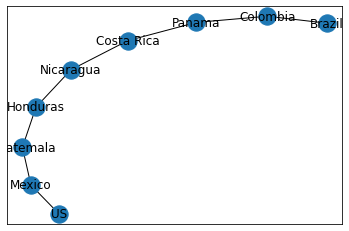

In [166]:
if country_path:
    nx.draw_networkx(resultant_tree)

# Visualizando o grafo completo

In [167]:
cities_graph = nx.Graph()

cities_graph.add_nodes_from(list(graph.keys()))

for city in list(graph.keys()):
    for frontier in graph[city]:
        cities_graph.add_edge(city,frontier)

In [168]:
hv.Graph.from_networkx(cities_graph, nx.layout.spring_layout)

:Graph   [start,end]